<a href="https://colab.research.google.com/github/wellmej/DataScienceUseCases/blob/main/Case4_My_Operations_Department_Skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK #1: UNDERSTAND THE PROBLEM STATEMENT AND BUSINESS CASE


<table>
  <tr><td>
    <img src="https://drive.google.com/uc?id=15eGnAbma5Q_j9CZZKi46Gh3-EpgSWYOV"
         alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1. Classifying disease using Deep Learning 
  </td></tr>
</table>


![alt text](https://drive.google.com/uc?id=19BuQ5m0xZWC7vQN4jX9lukmJ4aE0EkL8)

![alt text](https://drive.google.com/uc?id=10tbeSkGZ0xdHtqTGhYwHhb9PPURw0BfD)

# TASK #2: IMPORT LIBRARIES AND DATASET

In [3]:
# This is a custom dataset that contains covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray iamges and normal person x-ray images.
# Each class contains 133 images.
# Dataset Source:
# https://github.com/ieee8023/covid-chestxray-dataset 
# https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [4]:
# You will need to mount your drive using the following commands:
# For more information regarding mounting, please check this out: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory
# 
# This google.colab mount command will give you access to your own google storage
# area. You can maintain it via your goggle account. Signon to your account, select Drive from the box of circles icon

from google.colab import drive
drive.mount('/content/drive')
#drive.mount("/content/drive", force_remount=True)

# You have to include the full link to the csv file containing your dataset
#C:\Users\jrwel\Documents\Udemy\Data Science Real-World Case Studies\Data\Case4
#X_Ray_Directory = 'C:/Users/jrwel/Documents/Udemy/Data Science Real-World Case Studies/Data/Case4/Dataset'
#employee_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data Science Case Studies/Case1/Human_Resources.csv')
#employee_df = pd.read_csv('C:/Users/jrwel/Documents/Udemy/Data Science Real-World Case Studies/Data/Case1/Human_Resource.csv')
#employee_df = pd.read_csv(hr_file)
#employee_df


Mounted at /content/drive


In [5]:
# Specify training data directory
#X_Ray_Directory = '/content/drive/Users/jrwel/Documents/Udemy/Data Science Real-World Case Studies/Data/Case4/Dataset'
X_Ray_Directory = '/content/drive/MyDrive/Colab Notebooks/Data Science Case Studies/Case4/Dataset'
X_Ray_Validation = '/content/drive/MyDrive/Colab Notebooks/Data Science Case Studies/Case4/Dataset'
#X_Ray_Directory = '/content/drive/My Drive/Colab Notebook/Chest_X_Ray/train'

#
# Note: X_Ray_Directory which is the Case4/Dataset folder is for training the model
#       X_Ray_Directory_Test is the Case4/Test folder, used to test the model.
#

In [6]:
# List the folders in the directory
os.listdir(X_Ray_Directory)

['3', '2', '0', '1']

In [7]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [8]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing
train_generator = image_generator.flow_from_directory(batch_size=40, directory=X_Ray_Directory,shuffle=True, target_size=(256, 256), class_mode = 'categorical', subset='training')


Found 428 images belonging to 4 classes.


In [9]:
#----------------------------------------------------------------------------------------
#  Change to 'validation' subset
#----------------------------------------------------------------------------------------
validation_generator = image_generator.flow_from_directory(batch_size=40, directory=X_Ray_Directory,shuffle=True, target_size=(256, 256), class_mode = 'categorical', subset='validation')

Found 104 images belonging to 4 classes.


In [10]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [11]:
train_images.shape # Color photos, so 40 images of 256 by 256 pixels for 3 color intensities (red, blue, green) 

(40, 256, 256, 3)

In [12]:
train_labels.shape

(40, 4)

In [13]:
#------------------------------------------
# 1,0,0,0 = Healthy Patient
# 0,1,0,0 = Covid-19 Patient
# 0,0,1,0 = Bacterial Pneumonia
# 0,0,0,1 = Viral Pneumonia
#
#  Assumes only one disease per patient
#------------------------------------------

train_labels

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]],

In [14]:
# labels Translator 
label_names = {0: '0-Covid-19', 1: '1-Normal', 2: '2-Viral Pneumonia', 3: '3-Bacterial Pneumonia'}

# TASK #3: VISUALIZE DATASET

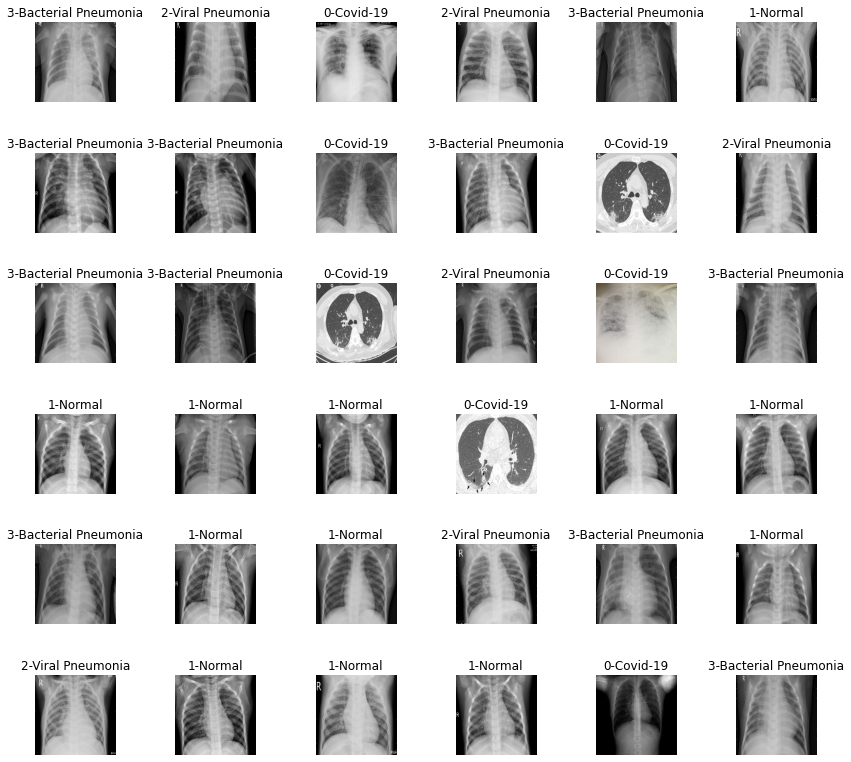

In [15]:
#----------------------------------------------------------------------
#  Create grid of 6 x 6 images (36 totsl) to display image and the
#  the label of the figure
#----------------------------------------------------------------------
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (14,14))
axes = axes.ravel()

for i in np.arange(0, L*W):
  axes[i].imshow(train_images[i])
  axes[i].set_title(label_names[np.argmax(train_labels[i])])
  axes[i].axis('off')

plt.subplots_adjust(wspace= 0.75)

In [16]:
np.argmax(train_labels[1])

2

# TASK #4: UNDERSTAND THE THEORY AND INTUITION BEHIND CONVOLUTIONAL NEURAL NETWORKS

![alt text](https://drive.google.com/uc?id=176TJGdJtNZmX4J5QyeI8W_YS5f1gg5VS)

![alt text](https://drive.google.com/uc?id=1340UvqbXc-sy6cIuVg7ZbOwcga2JxfkP)

![alt text](https://drive.google.com/uc?id=1hngDlUf9JnwUhPII-Ah7KTtcvoeTI9m8)

![alt text](https://drive.google.com/uc?id=1nt8iX7H2LEhaWgGCi_NIb05DMQEoJVfI)

# TASK #5: UNDERSTAND THE THEORY AND INTUITION BEHIND TRANSFER LEARNING

![alt text](https://drive.google.com/uc?id=1Wnti2DSmA2qMRsgkD7Z_MJkmed0bJZTN)

![alt text](https://drive.google.com/uc?id=1Chdq0gdnHGYDDb50pMMtcTOZMr0u37Iz)

![alt text](https://drive.google.com/uc?id=14niGb232X6l8OD1dMT4a_u3fjh_jKuMS)

![alt text](https://drive.google.com/uc?id=1dye4zWALCDu8a1a-58HfZk4On4nVuizV)

# TASK #6: IMPORT MODEL WITH PRETRAINED WEIGHTS

In [17]:

#----------------------------------------------------------------------------------
# Build our Base Model using the weights from an pre-trained Neural
# network (ResNet50) that has been trained on the "iamgenet" library of
# images. 
#
# weights = 'imagenet'  <- use pretrained model based on imagenet photos
# input_tensor = shape of our lung images which is 256 x 256 x 3
# include_top = False <- We will create our own top  of the model
#----------------------------------------------------------------------------------
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor=Input(shape = (256, 256, 3)))

94773248/94765736 [==============================] - 1s 0us/step


In [18]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [19]:
# freezing layers in the model
# Keep last 10 layers to be trainable
for layer in basemodel.layers[:-10]:
  layers.trainable = False

# TASK #7: BUILD AND TRAIN DEEP LEARNING MODEL

In [20]:
#-----------------------------------------------------------------------------------------
# Add our own classification head to the model to complete the deep learning model
#-----------------------------------------------------------------------------------------
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name = 'flatten') (headmodel)

#---------------------------
# Add first dense layer
#---------------------------
headmodel = Dense(256, activation = 'relu') (headmodel)  # RELU: Rectified Linear Unit
# Avoid overfitting - drop 30% of the neurons
headmodel = Dropout(0.3)(headmodel)

#-------------------------------------------
# Add another (2nd) dense layer of neurons
#-------------------------------------------
headmodel = Dense(256, activation = 'relu') (headmodel)  # RELU: Rectified Linear Unit
# Avoid overfitting - drop 20% of the neurons
headmodel = Dropout(0.25)(headmodel)

#-------------------------------------------
# Add another (3rd) dense layer of neurons
#-------------------------------------------
headmodel = Dense(256, activation = 'relu') (headmodel)  # RELU: Rectified Linear Unit
# Avoid overfitting - drop 20% of the neurons
headmodel = Dropout(0.3)(headmodel)

# Add output layer, one layer for each category
#  0, 1, 2, 3 = Categories of Lung images (Normal, Covid-19, Bacterial, Viral)
headmodel = Dense(4, activation='softmax')(headmodel)  # Use softmax activation for output layer



#
# Note: The 256 and 128 neurons above is by trial and error and can be modified
#       and tweaked. Also percentage of dropped neurons is from trial and error
#       but in general 20-30% is used

In [21]:
#--------------------------------------------------------------------
# Build final model - using the transfer learning from Resnet50
#--------------------------------------------------------------------
model = Model(inputs=basemodel.input, outputs = headmodel)

In [22]:
#-----------------------------------------------------------------
# Compile the Model
#
#  Since our output is castegorical (4 categories of types of lung images)
#  use "categorical_crossentropy" as the loss function
#
#  Optimizer is standard RMSprop with a learning rate of 0.0001 (similar to gradient decent)
#
#  Metrics = measure accuracy
#-----------------------------------------------------------------
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(lr = 1e-4), metrics = ['accuracy'])

In [23]:
# using early stopping to exit training if validation loss is not decreasing after certain number of epochs (patience)
# to avoid overfitting
# Will stop when it finds the training error is going down but the validation error is going up, meaing the model is overfitting and
# the model is no longer good at generalzing
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 20) # wait for 20 epochs before doing early stopping

#
# save the best model with lower validation loss
#
checkpointer = ModelCheckpoint(filepath = 'weights.hdf5', verbose = 1, save_best_only=True)

In [24]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory=X_Ray_Directory,shuffle=True, target_size=(256, 256), 
                                                      class_mode = 'categorical', subset='training')

val_generator = image_generator.flow_from_directory(batch_size = 4, directory=X_Ray_Directory,shuffle=True, target_size=(256, 256), 
                                                      class_mode = 'categorical', subset='validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [25]:
#--------------------------------------------------------------------------
# Fit the model to the training data
#
# steps_per_epoch = train_generator / 4
# epochs = 5  (Can be increased to 50 for more accuracy)
#
#--------------------------------------------------------------------------
history = model.fit_generator(train_generator, epochs = 25, validation_data=val_generator, callbacks=[checkpointer, earlystopping])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
107/107 [==============================] - 126s 1s/step - loss: 1.2589 - accuracy: 0.4609 - val_loss: 3.1927 - val_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 3.19265, saving model to weights.hdf5
Epoch 2/25
107/107 [==============================] - 13s 123ms/step - loss: 0.3660 - accuracy: 0.8871 - val_loss: 9.5895 - val_accuracy: 0.2500

Epoch 00002: val_loss did not improve from 3.19265
Epoch 3/25
107/107 [==============================] - 13s 122ms/step - loss: 0.3570 - accuracy: 0.9133 - val_loss: 39.8856 - val_accuracy: 0.2500

Epoch 00003: val_loss did not improve from 3.19265
Epoch 4/25
107/107 [==============================] - 13s 124ms/step - loss: 0.1994 - accuracy: 0.9438 - val_loss: 11.5483 - val_accuracy: 0.2500

Epoch 00004: val_loss did not improve from 3.19265
Epoch 5/25
107/107 [==============================] - 13s 123ms/step - loss: 0.3069 - accuracy: 0.9344 - val_loss: 19.4735 - val_accuracy: 0.2404

Epoch 00005: val_loss did not impro

# TASK #8: EVALUATE TRAINED DEEP LEARNING MODEL

In [26]:
#------------------------------------------------------
# Examine history keys
#------------------------------------------------------
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0, 0.5, 'Training accuracy and Loss')

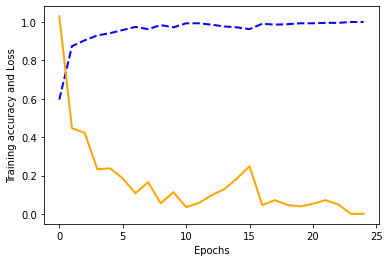

In [27]:
#------------------------------------------------------------------------
# Plot model Accuracy ad Loss history for Training dataset
#
# Note: The plot will be over the number of epochs (x-axis)
#------------------------------------------------------------------------
plt.plot(history.history['accuracy'], linestyle='dashed', color = 'blue', linewidth = 2)  # Blue Line dashed
plt.plot(history.history['loss'], color = 'orange', linewidth = 2)                        # Orange Line
plt.xlabel("Epochs")
plt.ylabel('Training accuracy and Loss')

Text(0, 0.5, 'Validation Loss')

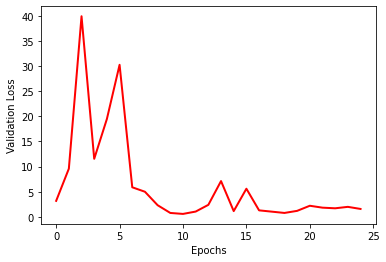

In [28]:
#------------------------------------------------------------------------
# Plot model Loss history for Validation dataset
#
# Note: The plot will be over the number of epochs (x-axis)
#------------------------------------------------------------------------
#plt.plot(history.history['val_accuracy'], linestyle='dashed', color = 'green', linewidth = 2)  # Green Line dashed
plt.plot(history.history['val_loss'], color = 'red', linewidth = 2)                            # Red Line
plt.xlabel("Epochs")
plt.ylabel('Validation Loss')

Text(0, 0.5, 'Validation Accuracy')

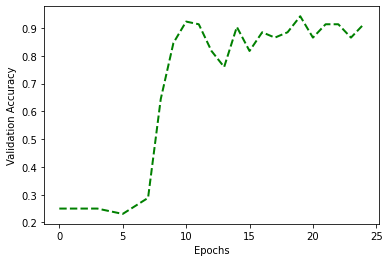

In [29]:
#------------------------------------------------------------------------
# Plot model Accuracy history for Validation dataset
#
# Note: The plot will be over the number of epochs (x-axis)
#------------------------------------------------------------------------
plt.plot(history.history['val_accuracy'], linestyle='dashed', color = 'green', linewidth = 2)  # Green Line dashed
#plt.plot(history.history['val_loss'], color = 'red', linewidth = 2)                            # Red Line
plt.xlabel("Epochs")
plt.ylabel('Validation Accuracy')

In [30]:
#####test_directory = 'conent/drive/My Drive/Colab Notebooks/Chest_X_Ray/Test'
X_Ray_Directory_Test = '/content/drive/MyDrive/Colab Notebooks/Data Science Case Studies/Case4/Test'

#
#  Note: The Test data folder is data the model has never seen yey, that is very important
#

In [32]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = X_Ray_Directory_Test, target_size = (256, 256),
                                              class_mode = 'categorical', shuffle = True)
#evaluate = model.evaluate_generator(test_generator, steps = test_generator.n //4, verbose = 1)

Found 40 images belonging to 4 classes.


In [33]:
test_generator.n

40

In [34]:
#-----------------------------------------
# Evaluate model on test dataset
# 
# Print out the accuracy based on the test data
#-----------------------------------------
evaluate = model.evaluate_generator(test_generator, steps = test_generator.n //4, verbose = 1)
print ('Test Accuracy: {}'.format(evaluate[1]))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


10/10 [==============================] - 1s 6ms/step - loss: 5.0435 - accuracy: 0.8000
Test Accuracy: 0.800000011920929


In [35]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


In [37]:
#--------------------------------------------------------------------------
# Prepare to Print matrix showing
# for each image, what the prediction was, what the original image actually
# was, and print out the image itself
#--------------------------------------------------------------------------
prediction = []
original = []
image = []

for i in range(len(os.listdir(X_Ray_Directory_Test))):
  for item in os.listdir(os.path.join(X_Ray_Directory_Test, str(i))):
    img = cv2.imread(os.path.join(X_Ray_Directory_Test, str(i), item))
    img = cv2.resize(img, (256, 256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)



In [38]:
score = accuracy_score(original, prediction)
print ('Test Accuracy: {}'.format(score))

Test Accuracy: 0.8


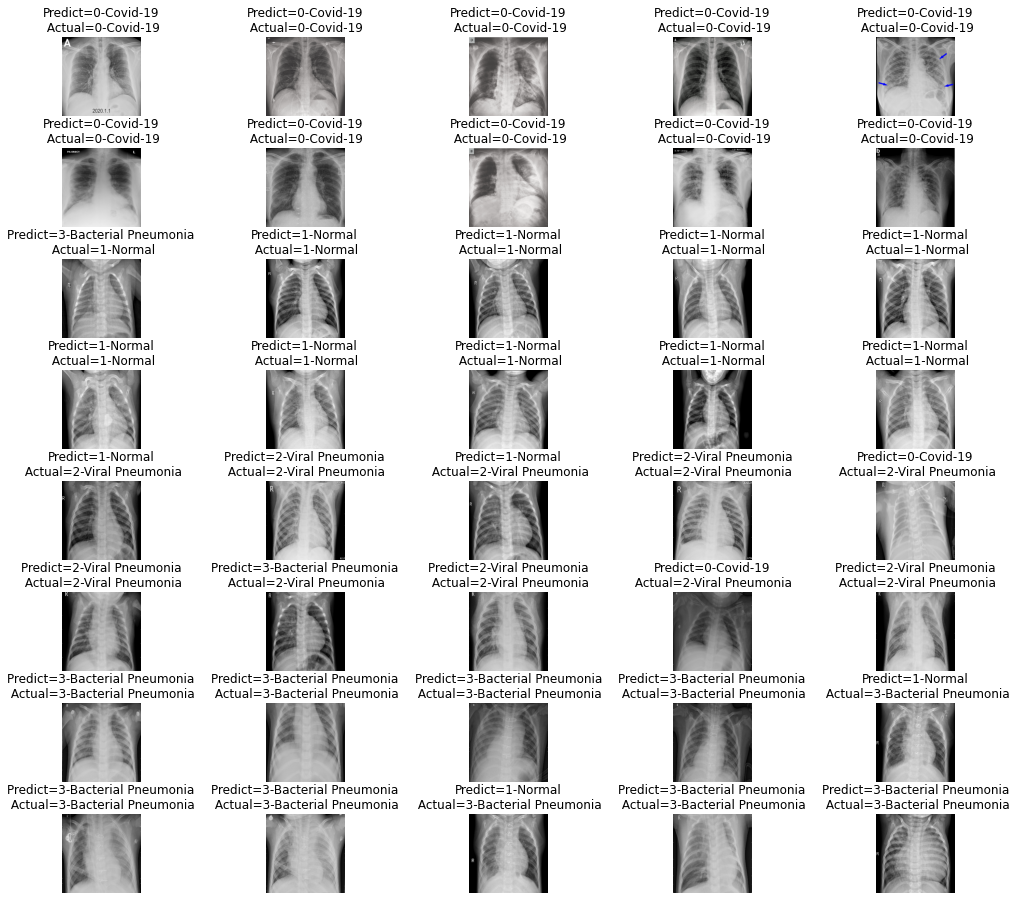

In [43]:
L = 8
W = 5

fig, axes = plt.subplots(L, W, figsize=(16,16))
axes = axes.ravel()

for i in np.arange(0, L*W):
  axes[i].imshow(image[i])
  axes[i].set_title('Predict={}\n Actual={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
  axes[i].axis('off')

plt.subplots_adjust(wspace = 1.6)

In [45]:
#-----------------------------------------------------------------------
# Print Classification Report
#-----------------------------------------------------------------------
print (classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.69      0.90      0.78        10
           2       1.00      0.50      0.67        10
           3       0.80      0.80      0.80        10

    accuracy                           0.80        40
   macro avg       0.83      0.80      0.79        40
weighted avg       0.83      0.80      0.79        40



Text(0.5, 1.0, 'Confusion Matrix')

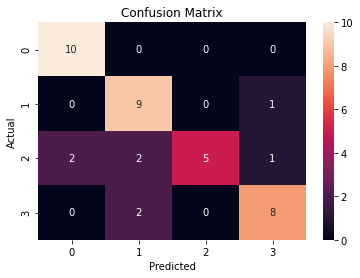

In [47]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

# EXCELLENT JOB! YOU SHOULD BE PROUD OF YOUR NEWLY ACQUIRED SKILLS